In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName('CreditCardFraudDetection').master("local[*]").config("spark.driver.memory", "4g").config("spark.sql.shuffle.partitions", "4").getOrCreate()

print(f"Spark Session Created with version: {spark.version}")

Spark Session Created with version: 4.0.1


## Import Data

In [9]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [13]:
transactions_raw = spark.read.csv(f"{base}/transactions_data.csv", header=True, inferSchema=True)
cards_raw        = spark.read.csv(f"{base}/cards_data.csv", header=True, inferSchema=True)
users_raw        = spark.read.csv(f"{base}/users_data.csv", header=True, inferSchema=True)


### Transactions

In [15]:
transactions_raw.printSchema()
transactions_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {transactions_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)

-RECORD 0-----------------------------
 id             | 7475327             
 date           | 2010-01-01 00:01:00 
 client_id      | 1556                
 card_id        | 2972                
 amount         | $-77.00             
 use_chip       | Swipe Transaction   
 merchant_id    | 59935               
 merchant_city  | Beulah              
 merchant_state | ND                  
 zip            | 58523.0             
 mcc            | 5499                
 errors         | NULL                
-RECORD 1

### Cards

In [16]:
cards_raw.printSchema()
cards_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {cards_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- expires: string (nullable = true)
 |-- cvv: integer (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: string (nullable = true)
 |-- acct_open_date: string (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)

-RECORD 0---------------------------------
 id                    | 4524             
 client_id             | 825              
 card_brand            | NULL             
 card_type             | Debit            
 card_number           | 4344676511950444 
 expires               | 12/2022          
 cvv                   | 623              
 has_chip              | YES              
 num_cards_issued      | 2                
 credit

### Users

In [17]:
users_raw.printSchema()
users_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {users_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- per_capita_income: string (nullable = true)
 |-- yearly_income: string (nullable = true)
 |-- total_debt: string (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)

-RECORD 0-------------------------------------
 id                | 825                      
 current_age       | 53                       
 retirement_age    | 66                       
 birth_year        | 1966                     
 birth_month       | 11                       
 gender            | Female                   
 address           | 462 Rose Lane            
 latitude        

### Data Quality Check

# Check for nulls and duplicates
def data_quality_check(df, name):
    print(f"\n=== {name} Quality Check ===")
    
    print("Null counts:")
    # df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

    null_counts_df = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    n_cols = len(df.columns)
    stack_string = f"stack({n_cols}, " + ", ".join([f"'{c}', `{c}`" for c in df.columns]) + ")"
    
    # 3. Select, filter, and show
    null_counts_df.select(expr(stack_string).alias("column_name", "null_count")) \
        .filter(col("null_count") > 0) \
        .show()
    
    # Total rows vs distinct rows
    total = null_counts_df.count()
    distinct = null_counts_df.distinct().count()
    print(f"Total rows: {total}")
    print(f"Distinct rows: {distinct}")
    print(f"Duplicates: {total - distinct}")

data_quality_check(transactions_raw, "TRANSACTIONS")
data_quality_check(cards_raw, "CARDS")
data_quality_check(users_raw, "USERS")

### Deeper transaction data analysis

In [18]:
transactions_raw.groupby("errors").count().orderBy(desc("count")).show(truncate=False)

+-------------------------------------+--------+
|errors                               |count   |
+-------------------------------------+--------+
|NULL                                 |13094522|
|Insufficient Balance                 |130902  |
|Bad PIN                              |32119   |
|Technical Glitch                     |26271   |
|Bad Card Number                      |7767    |
|Bad Expiration                       |6161    |
|Bad CVV                              |6106    |
|Bad Zipcode                          |1126    |
|Bad PIN,Insufficient Balance         |293     |
|Insufficient Balance,Technical Glitch|243     |
|Bad Card Number,Insufficient Balance |71      |
|Bad PIN,Technical Glitch             |70      |
|Bad CVV,Insufficient Balance         |57      |
|Bad Expiration,Insufficient Balance  |47      |
|Bad Card Number,Bad CVV              |38      |
|Bad Card Number,Bad Expiration       |33      |
|Bad Expiration,Bad CVV               |32      |
|Bad Expiration,Tech

### Which merchant causing these errors?

In [20]:
transactions_raw.groupby("merchant_id", "errors").count().filter(col("errors").isNotNull()).orderBy(desc("count")).show()

+-----------+--------------------+-----+
|merchant_id|              errors|count|
+-----------+--------------------+-----+
|      27092|Insufficient Balance|14662|
|      59935|Insufficient Balance| 8397|
|      61195|Insufficient Balance| 6110|
|      60569|Insufficient Balance| 4848|
|      22204|Insufficient Balance| 4383|
|      43293|Insufficient Balance| 4317|
|      26810|Insufficient Balance| 2732|
|      39021|Insufficient Balance| 2495|
|      20561|Insufficient Balance| 2423|
|      27092|             Bad PIN| 2310|
|      39021|     Bad Card Number| 2125|
|      50783|Insufficient Balance| 1874|
|      75781|Insufficient Balance| 1763|
|      39021|      Bad Expiration| 1746|
|      59935|             Bad PIN| 1726|
|      39021|             Bad CVV| 1666|
|      73186|Insufficient Balance| 1613|
|      48919|Insufficient Balance| 1322|
|      61195|             Bad PIN| 1241|
|      59935|    Technical Glitch| 1213|
+-----------+--------------------+-----+
only showing top

### Which users made most errors?

In [19]:
user_errors = transactions_raw.filter(col('errors').isNotNull()) \
    .join(users_raw, transactions_raw['client_id'] == users_raw['id'])

# 3. Use users_raw['id'] instead of just 'id' to avoid ambiguity errors
top_user_errors = user_errors.groupby(users_raw['id']).count().orderBy(desc('count'))

top_user_errors.show(truncate=False)

+----+-----+
|id  |count|
+----+-----+
|954 |2935 |
|1888|2109 |
|464 |1196 |
|1098|1125 |
|1696|953  |
|425 |847  |
|1424|822  |
|1382|821  |
|373 |816  |
|114 |796  |
|476 |741  |
|1885|713  |
|53  |675  |
|1963|654  |
|96  |617  |
|1340|611  |
|208 |601  |
|1797|599  |
|154 |593  |
|1241|552  |
+----+-----+
only showing top 20 rows


In [22]:
transactions_raw = transactions_raw.withColumn(
    "amount_clean",
    abs(regexp_replace(col("amount"), r'[$\,]', '').cast("double"))
)

### Impossible travel

In [21]:
windowSpec = Window.partitionBy("client_id", "card_id").orderBy("date")

# Calculate location and time differences
travel_df = transactions_raw.withColumn("prev_zip", lag("zip").over(windowSpec)) \
                            .withColumn("prev_merchant_city", lag("merchant_city").over(windowSpec)) \
                            .withColumn("prev_merchant_state", lag("merchant_state").over(windowSpec)) \
                            .withColumn("prev_date", lag("date").over(windowSpec))

# Time difference in minutes
travel_df = travel_df.withColumn("diff_minutes",
    (unix_timestamp("date") - unix_timestamp("prev_date")) / 60
)

# Calculate if ZIP changed
travel_df = travel_df.withColumn("zip_changed",
    when((col("zip") != col("prev_zip")) & (col("prev_zip").isNotNull()), 1).otherwise(0)
)

# Flag impossible travel
travel_df = travel_df.withColumn("impossible_travel",
    when(
        (col("zip_changed") == 1) &
        (col("diff_minutes") < 60) &  # Changed to 60 minutes
        (col("diff_minutes") > 0),    # Avoid same-second duplicates
        1
    ).otherwise(0)
)

print("=== IMPOSSIBLE TRAVEL STATISTICS ===")
travel_df.groupBy("impossible_travel").count().show()

# Show examples
print("\n=== IMPOSSIBLE TRAVEL EXAMPLES ===")
impossible_cases = travel_df.filter(col("impossible_travel") == 1) \
                            .select(
                                "client_id", "card_id",
                                "prev_zip", "zip",
                                "prev_merchant_city", "merchant_city",
                                "prev_merchant_state", "merchant_state",
                                "prev_date", "date",
                                "diff_minutes",
                                "amount"
                            )

impossible_cases.show(20, truncate=False)
print(f"\nTotal impossible travel cases: {impossible_cases.count():,}")

=== IMPOSSIBLE TRAVEL STATISTICS ===
+-----------------+--------+
|impossible_travel|   count|
+-----------------+--------+
|                0|12841692|
|                1|  464223|
+-----------------+--------+


=== IMPOSSIBLE TRAVEL EXAMPLES ===
+---------+-------+--------+-------+------------------+-------------+-------------------+--------------+-------------------+-------------------+------------+------+
|client_id|card_id|prev_zip|zip    |prev_merchant_city|merchant_city|prev_merchant_state|merchant_state|prev_date          |date               |diff_minutes|amount|
+---------+-------+--------+-------+------------------+-------------+-------------------+--------------+-------------------+-------------------+------------+------+
|2        |3593   |10460.0 |10469.0|Bronx             |Bronx        |NY                 |NY            |2015-12-19 21:55:00|2015-12-19 22:04:00|9.0         |$32.45|
|2        |3593   |10462.0 |10460.0|Bronx             |Bronx        |NY                 |NY 

### Add impossible travel col to the dataset

In [23]:
transactions_raw = travel_df.withColumn("travel_risk_level",
    when(
        (col("zip_changed") == 1) &
        (col("prev_merchant_state") != col("merchant_state")) &
        (col("diff_minutes") < 30),
        "critical"  # Different states in 30 min = likely fraud
    )
    .when(
        (col("zip_changed") == 1) &
        (col("diff_minutes") < 60),
        "high"  # Different ZIPs in 1 hour = suspicious
    )
    .when(
        (col("zip_changed") == 1) &
        (col("diff_minutes") < 180),
        "medium"  # Different ZIPs in 3 hours = monitor
    )
    .otherwise("low")
)

print("=== TRAVEL RISK DISTRIBUTION ===")
transactions_raw.groupBy("travel_risk_level").count().orderBy(desc("count")).show()

=== TRAVEL RISK DISTRIBUTION ===
+-----------------+--------+
|travel_risk_level|   count|
+-----------------+--------+
|              low|12295534|
|           medium|  542117|
|             high|  448058|
|         critical|   20206|
+-----------------+--------+



### Card testing

In [26]:
transactions_raw.columns


['id',
 'date',
 'client_id',
 'card_id',
 'amount',
 'use_chip',
 'merchant_id',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'errors',
 'prev_zip',
 'prev_merchant_city',
 'prev_merchant_state',
 'prev_date',
 'diff_minutes',
 'zip_changed',
 'impossible_travel',
 'travel_risk_level',
 'total_txn_count_10min',
 'is_high_velocity']

In [27]:
transactions_raw.select("amount").show(5, truncate=False)


+-------+
|amount |
+-------+
|$-77.00|
|$14.57 |
|$80.00 |
|$200.00|
|$46.41 |
+-------+
only showing top 5 rows


In [28]:
high_velocity = transactions_raw.filter(col("is_high_velocity") == 1) \
    .select(
        "client_id", "card_id", "date",
        "amount",                      # <-- use amount
        "total_txn_count_10min",
        "merchant_city", "errors"
    )


In [29]:
transactions_raw = transactions_raw.withColumn(
    "error_type",
    when(col("errors").contains("Bad PIN"), "card_testing")
    .when(col("errors").contains("Bad Card Number"), "card_testing")
    .when(col("errors").contains("Bad CVV"), "card_testing")
    .when(col("errors").contains("Bad Expiration"), "card_testing")
    .when(col("errors").contains("Bad Zipcode"), "card_testing")
    .when(col("errors").contains("Insufficient Balance"), "legitimate")
    .when(col("errors").contains("Technical Glitch"), "legitimate")
    .otherwise("no_error")
)

In [30]:
transactions_raw.groupBy("error_type").count().show()

+------------+--------+
|  error_type|   count|
+------------+--------+
|card_testing|   53977|
|    no_error|13094522|
|  legitimate|  157416|
+------------+--------+



In [31]:
transactions_raw = transactions_raw.withColumn(
    "hour",
    hour(col("date"))
)

In [32]:
transactions_raw = transactions_raw.withColumn(
    "is_suspected_fraud",
    when(
        # High velocity fraud
        (col("is_high_velocity") == 1) |
        # Impossible travel
        (col("impossible_travel") == 1) |
        # Card testing errors
        (col("errors").rlike("Bad PIN|Bad Card Number|Bad CVV|Bad Expiration|Bad Zipcode")),
        1
    ).otherwise(0)
)

In [33]:
transactions_raw = transactions_raw.withColumn("year", year("date")) \
                                   .withColumn("month", month("date"))

In [34]:
transactions_raw.groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2010|    1|101209|
|2010|    2| 93470|
|2010|    3|103345|
|2010|    4|100169|
|2010|    5|104773|
|2010|    6|102677|
|2010|    7|106034|
|2010|    8|107547|
|2010|    9|103902|
|2010|   10|106150|
|2010|   11|103721|
|2010|   12|107883|
|2011|    1|107821|
|2011|    2| 97395|
|2011|    3|108235|
|2011|    4|105662|
|2011|    5|108946|
|2011|    6|106239|
|2011|    7|110196|
|2011|    8|111001|
+----+-----+------+
only showing top 20 rows


In [35]:
partitions = transactions_raw.select("year", "month").distinct().collect()

print(f"\nTotal partitions: {len(partitions)}")


Total partitions: 118


In [36]:
indexer = StringIndexer(inputCol="use_chip", outputCol="chip_indexed")
transactions_raw = indexer.fit(transactions_raw).transform(transactions_raw)

In [37]:
transactions_raw.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- prev_zip: double (nullable = true)
 |-- prev_merchant_city: string (nullable = true)
 |-- prev_merchant_state: string (nullable = true)
 |-- prev_date: timestamp (nullable = true)
 |-- diff_minutes: double (nullable = true)
 |-- zip_changed: integer (nullable = false)
 |-- impossible_travel: integer (nullable = false)
 |-- travel_risk_level: string (nullable = false)
 |-- total_txn_count_10min: long (nullable = false)
 |-- is_high_velocity: integer (nullable = false)
 |-- error_type: string (nullable = fals

In [38]:
feature_cols = ["amount_clean", "hour", "chip_indexed", "is_high_velocity", "impossible_travel"]

In [43]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import DoubleType

transactions_raw = transactions_raw.withColumn(
    "amount_clean",
    regexp_replace(col("amount").cast("string"), r"[\$,]", "").cast(DoubleType())
)


In [44]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
output = assembler.transform(transactions_raw)

output = output.withColumn("label",
    when((col("errors").isNotNull()) | (col("impossible_travel") == 1), 1)
    .otherwise(0)
)

# 3. Split data into Training (80%) and Testing (20%)
train_data, test_data = output.randomSplit([0.8, 0.2])

In [45]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

model = rf.fit(train_data)

predictions = model.transform(test_data)

In [47]:

batch_results = []
batch_models = []

# Reuse evaluator (no need to recreate each loop)
evaluator = BinaryClassificationEvaluator(labelCol="label")

for i, partition in enumerate(partitions[:3]):  # Start with 3 months as test
    year_val = partition["year"]
    month_val = partition["month"]

    print(f"\n{'='*60}")
    print(f"Processing Batch {i+1}: {year_val}-{month_val:02d}")
    print(f"{'='*60}")

    # Load batch
    batch = transactions_raw.filter(
        (col("year") == year_val) & (col("month") == month_val)
    )

    batch_count = batch.count()
    print(f"Batch size: {batch_count:,} rows")

    # Skip if too small
    if batch_count < 1000:
        print("Batch too small, skipping...")
        continue

    # Feature engineering
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
    batch_features = assembler.transform(batch)

    batch_features = batch_features.withColumn(
        "label",
        when(col("is_suspected_fraud") == 1, 1).otherwise(0)
    )

    # Check label distribution
    label_dist = batch_features.groupBy("label").count().collect()
    print(f"Label distribution: {label_dist}")

    # Split + cache
    train, test = batch_features.randomSplit([0.8, 0.2], seed=42)
    train = train.cache()
    test = test.cache()

    # Train model on this batch
    rf = RandomForestClassifier(
        labelCol="label",
        featuresCol="features",
        numTrees=30,  # Reduced for speed
        maxDepth=8,
        seed=42
    )

    print("Training on batch...")
    model = rf.fit(train)

    # Evaluate
    predictions = model.transform(test)
    auc = evaluator.evaluate(predictions)
    print(f"Batch {i+1} AUC: {auc:.4f}")

    # Store results (train/test counts trigger jobs; keep if you need them)
    train_size = train.count()
    test_size = test.count()

    batch_results.append({
        "batch": f"{year_val}-{month_val:02d}",
        "train_size": train_size,
        "test_size": test_size,
        "auc": auc
    })

    # Save model (use a valid path; in Colab prefer /content or Drive)
    model_path = f"/content/models/rf_batch_{year_val}_{month_val:02d}"
    model.write().overwrite().save(model_path)
    batch_models.append(model_path)

    # Cleanup
    train.unpersist()
    test.unpersist()

    print(f"Saved model to: {model_path}")

# Summary
print("\n" + "="*60)
print("BATCH TRAINING SUMMARY")
print("="*60)
for result in batch_results:
    print(f"{result['batch']}: AUC={result['auc']:.4f}, Train={result['train_size']:,}, Test={result['test_size']:,}")



Processing Batch 1: 2010-10
Batch size: 106,150 rows
Label distribution: [Row(label=0, count=101585), Row(label=1, count=4565)]
Training on batch...
Batch 1 AUC: 0.9682
Saved model to: /content/models/rf_batch_2010_10

Processing Batch 2: 2011-01
Batch size: 107,821 rows
Label distribution: [Row(label=0, count=103382), Row(label=1, count=4439)]
Training on batch...
Batch 2 AUC: 0.9718
Saved model to: /content/models/rf_batch_2011_01

Processing Batch 3: 2010-01
Batch size: 101,209 rows
Label distribution: [Row(label=0, count=96667), Row(label=1, count=4542)]
Training on batch...
Batch 3 AUC: 0.9625
Saved model to: /content/models/rf_batch_2010_01

BATCH TRAINING SUMMARY
2010-10: AUC=0.9682, Train=85,095, Test=21,055
2011-01: AUC=0.9718, Train=86,408, Test=21,413
2010-01: AUC=0.9625, Train=81,125, Test=20,084


In [48]:
essential_cols = [
    "id", "date", "amount_clean", "hour", "chip_indexed",
    "is_high_velocity", "impossible_travel", "is_suspected_fraud"
]

# Filter to only needed columns
df_minimal = transactions_raw.select(essential_cols)

print(f"Original columns: {len(transactions_raw.columns)}")
print(f"Minimal columns: {len(df_minimal.columns)}")

# 2. Stratified sampling - balance classes
fraud_data = df_minimal.filter(col("is_suspected_fraud") == 1)
fraud_count = fraud_data.count()

print(f"\n=== DATA DISTRIBUTION ===")
print(f"Total fraud cases: {fraud_count:,}")

# Sample: ALL fraud + equal non-fraud
non_fraud_sample = df_minimal.filter(col("is_suspected_fraud") == 0) \
                             .sample(False, fraud_count / df_minimal.count(), seed=42)

# Combine
balanced_data = fraud_data.union(non_fraud_sample)
balanced_data = balanced_data.cache()  # Cache AFTER union

print(f"Balanced dataset: {balanced_data.count():,} rows")
balanced_data.groupBy("is_suspected_fraud").count().show()

# 3. Prepare features
feature_cols = ["amount_clean", "hour", "chip_indexed", "is_high_velocity", "impossible_travel"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

feature_data = assembler.transform(balanced_data)
feature_data = feature_data.withColumn("label", col("is_suspected_fraud"))

# 4. Train/test split
train, test = feature_data.randomSplit([0.8, 0.2], seed=42)

# CRITICAL: Cache splits
train = train.cache()
test = test.cache()

# Force materialization
train_count = train.count()
test_count = test.count()

print(f"\n=== SPLIT COMPLETE ===")
print(f"Training: {train_count:,} rows")
print(f"Test: {test_count:,} rows")

# 5. Train model (simplified)
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=20,  # Reduced to prevent disk overflow
    maxDepth=6,
    maxBins=24,
    seed=42
)

print("\n🔄 Training model...")
model = rf.fit(train)
print("✅ Training complete!")

# 6. Evaluate
predictions = model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)

print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion matrix
print("\n=== CONFUSION MATRIX ===")
predictions.groupBy("label", "prediction").count().show()

# Additional metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision = MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedPrecision"
).evaluate(predictions)

recall = MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedRecall"
).evaluate(predictions)

f1 = MulticlassClassificationEvaluator(
    labelCol="label", metricName="f1"
).evaluate(predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 7. Feature importance
print("\n=== FEATURE IMPORTANCE ===")
importances = model.featureImportances.toArray()
for feat, imp in sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# 8. Save model
os.makedirs("../models", exist_ok=True)
model_path = "../models/fraud_detection_rf_final"
model.write().overwrite().save(model_path)
print(f"\n✅ Model saved: {model_path}")

# 9. Cleanup
train.unpersist()
test.unpersist()
balanced_data.unpersist()

Original columns: 29
Minimal columns: 8

=== DATA DISTRIBUTION ===
Total fraud cases: 520,831
Balanced dataset: 1,020,990 rows
+------------------+------+
|is_suspected_fraud| count|
+------------------+------+
|                 1|520831|
|                 0|500159|
+------------------+------+


=== SPLIT COMPLETE ===
Training: 817,064 rows
Test: 203,926 rows

🔄 Training model...
✅ Training complete!

MODEL PERFORMANCE
AUC-ROC: 0.9634

=== CONFUSION MATRIX ===
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|93681|
|    1|       0.0|10414|
|    0|       0.0|99831|
+-----+----------+-----+

Precision: 0.9538
Recall: 0.9489
F1-Score: 0.9489

=== FEATURE IMPORTANCE ===
impossible_travel: 0.9780
is_high_velocity: 0.0145
chip_indexed: 0.0070
hour: 0.0004
amount_clean: 0.0002

✅ Model saved: ../models/fraud_detection_rf_final


DataFrame[id: int, date: timestamp, amount_clean: double, hour: int, chip_indexed: double, is_high_velocity: int, impossible_travel: int, is_suspected_fraud: int]

## Confusion Matrix

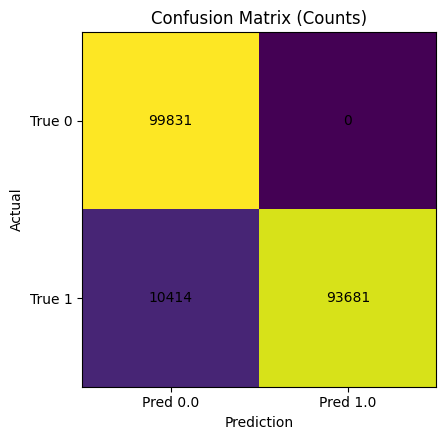

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


LABEL_COL = "label"
PRED_COL  = "prediction"

cm_pd = (predictions
         .groupBy(LABEL_COL, PRED_COL)
         .count()
         .toPandas())


labels = sorted(cm_pd[LABEL_COL].unique().tolist())
preds  = sorted(cm_pd[PRED_COL].unique().tolist())

mat = np.zeros((len(labels), len(preds)), dtype=int)
for _, r in cm_pd.iterrows():
    mat[labels.index(r[LABEL_COL]), preds.index(r[PRED_COL])] = int(r["count"])

fig, ax = plt.subplots(figsize=(5.5,4.5))
im = ax.imshow(mat)

ax.set_xticks(range(len(preds)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([f"Pred {p}" for p in preds])
ax.set_yticklabels([f"True {l}" for l in labels])
ax.set_title("Confusion Matrix (Counts)")
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, mat[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


### Error Distribution

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-21032417.py:2: SyntaxWarning: invalid escape sequence '\s'
  .withColumn("single_error", explode(split(col("errors"), ",\s*"))) \


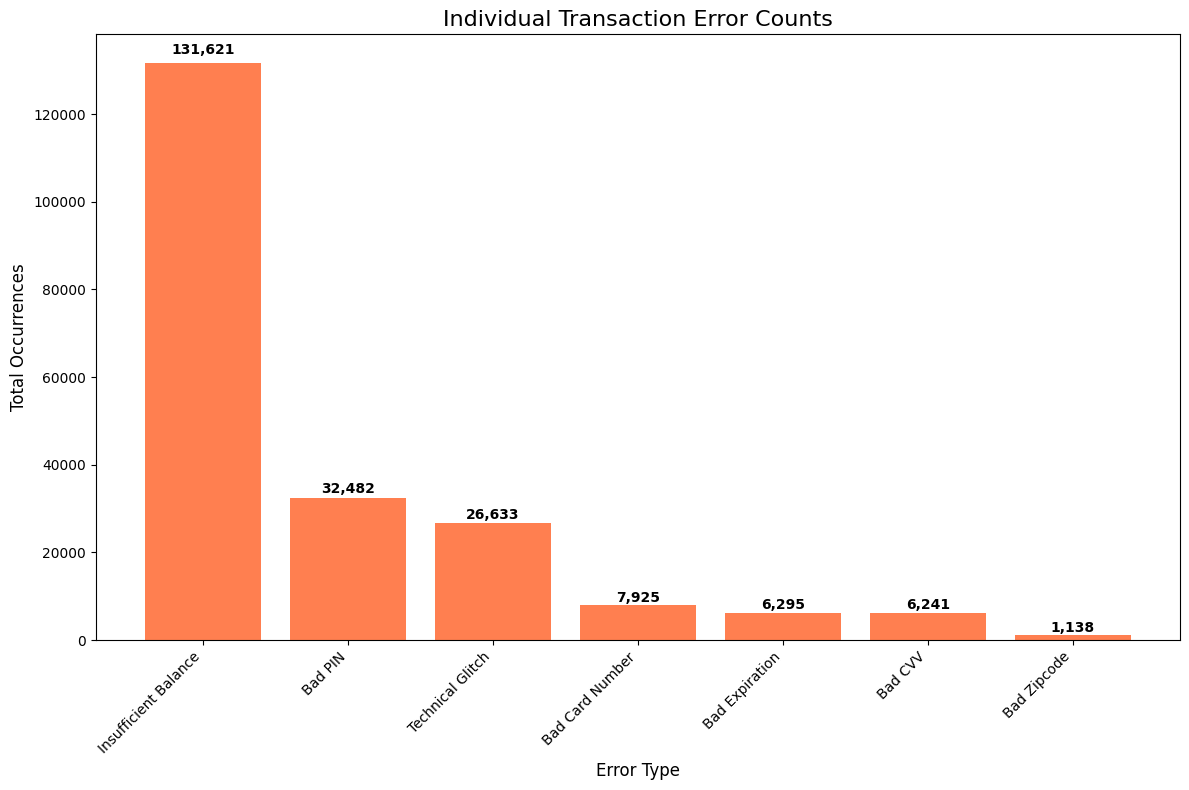

In [49]:
flattened_errors = transactions_raw.filter(col("errors").isNotNull()) \
    .withColumn("single_error", explode(split(col("errors"), ",\s*"))) \
    .withColumn("single_error", trim(col("single_error"))) \
    .groupBy("single_error") \
    .count() \
    .orderBy(desc("count")) \
    .toPandas()

plt.figure(figsize=(12, 8))

bars = plt.bar(flattened_errors['single_error'], flattened_errors['count'], color='#ff7f50')

plt.title('Individual Transaction Error Counts', fontsize=16)
plt.xlabel('Error Type', fontsize=12)
plt.ylabel('Total Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
             f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('flattened_errors_chart.png') # Saving for the environment
plt.show()

## Which age group made the most errors?

In [50]:
user_errors_with_bins = user_errors.withColumn(
    "age_group",
    when(col("current_age") <= 25, "18-25")
     .when(col("current_age") <= 40, "26-40")
     .when(col("current_age") <= 60, "41-60")
     .otherwise("60+")
)

# 2. Now aggregate
age_group_counts = user_errors_with_bins.groupBy("age_group").count().orderBy("age_group")

age_group_counts.show()

+---------+-----+
|age_group|count|
+---------+-----+
|    18-25|  669|
|    26-40|42183|
|    41-60|97653|
|      60+|70888|
+---------+-----+



/tmp/ipython-input-33388254.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='count', data=age_group_counts_pd, palette='viridis')


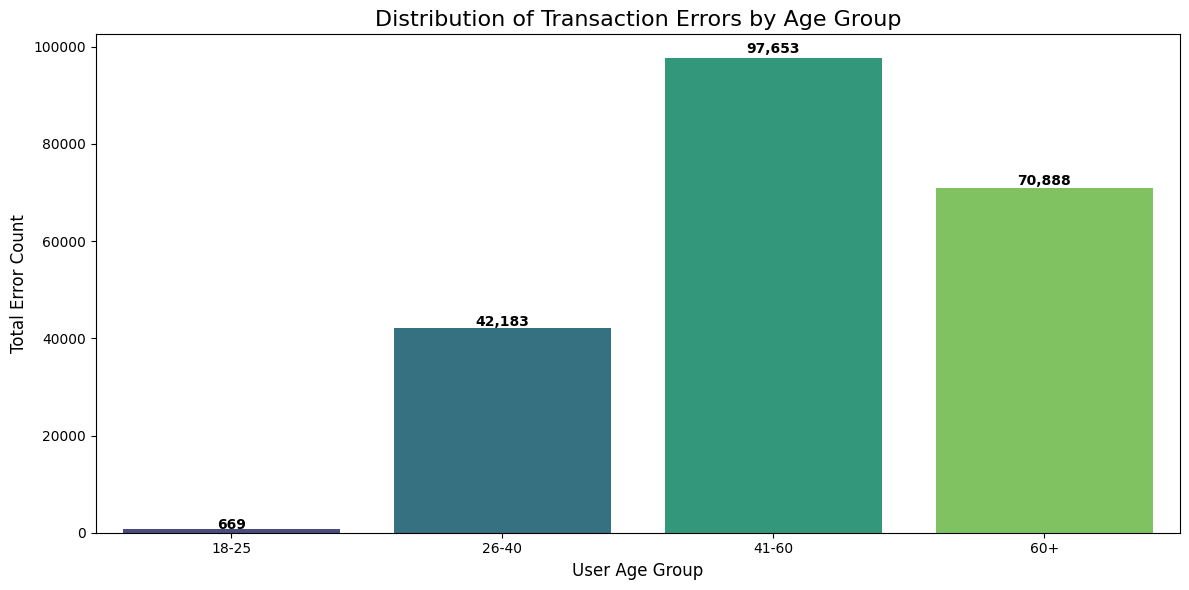

In [51]:
# 1. Create age groups and aggregate in Spark
age_group_counts_spark = user_errors.withColumn(
    "age_group",
    when(col("current_age") <= 25, "18-25")
     .when(col("current_age") <= 40, "26-40")
     .when(col("current_age") <= 60, "41-60")
     .otherwise("60+")
).groupBy("age_group").count().orderBy("age_group")

# 2. CONVERT TO PANDAS HERE (The "Fix")
# We do this now because the data is only 4 rows - very safe for memory.
age_group_counts_pd = age_group_counts_spark.toPandas()

# 3. Use the Pandas DataFrame for Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='count', data=age_group_counts_pd, palette='viridis')

plt.title('Distribution of Transaction Errors by Age Group', fontsize=16)
plt.xlabel('User Age Group', fontsize=12)
plt.ylabel('Total Error Count', fontsize=12)

# 4. Use the Pandas column for the labels
for i, v in enumerate(age_group_counts_pd['count']):
    plt.text(i, v + (v * 0.01), f'{int(v):,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [55]:
from pyspark.sql.functions import col, sum as _sum

user_spending = transactions_raw.groupBy("client_id").agg(
    _sum("amount_clean").alias("total_spent")
)


In [57]:
user_spending_tiers = user_spending.join(users_raw, user_spending.client_id == users_raw.id) \
    .withColumn("Credit_Tier",
        when(col("credit_score") >= 800, "7. Exceptional (800+)")
         .when(col("credit_score") >= 740, "6. Very Good (740-799)")
         .when(col("credit_score") >= 670, "5. Good (670-739)")
         .when(col("credit_score") >= 580, "4. Fair (580-669)")
         .otherwise("3. Poor (<580)")) \
    .select("Credit_Tier", "total_spent")


plot_df = user_spending_tiers.sample(False, 0.1, seed=42).toPandas()

/tmp/ipython-input-715171762.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Credit_Tier', y='total_spent', data=plot_df,


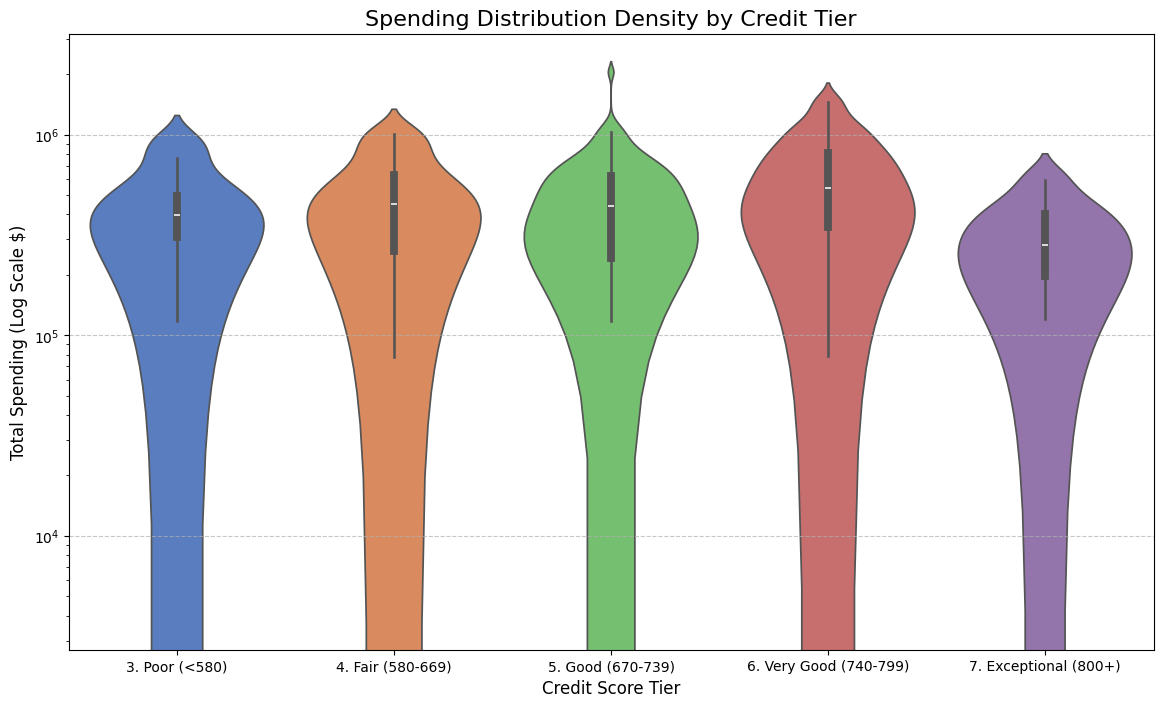

In [58]:
plt.figure(figsize=(14, 8))

# We use a log scale for the Y-axis because spending ranges from $1 to $100,000+
sns.violinplot(x='Credit_Tier', y='total_spent', data=plot_df,
               palette="muted", order=sorted(plot_df['Credit_Tier'].unique()))

plt.yscale('log') # CRITICAL: This allows us to see the $100 and $10,000 users on the same map
plt.title('Spending Distribution Density by Credit Tier', fontsize=16)
plt.xlabel('Credit Score Tier', fontsize=12)
plt.ylabel('Total Spending (Log Scale $)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Fraud Rate by High Velocity

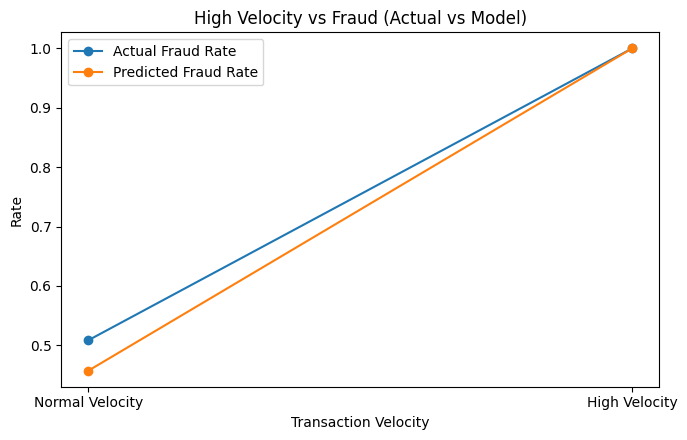

In [64]:
from pyspark.sql.functions import avg, col

vel_pd = (
    predictions
    .groupBy("is_high_velocity")
    .agg(
        avg(col("label")).alias("actual_fraud_rate"),
        avg(col("prediction")).alias("predicted_positive_rate")
    )
    .orderBy("is_high_velocity")
    .toPandas()
)

plt.figure(figsize=(7,4.5))
plt.plot(
    vel_pd["is_high_velocity"],
    vel_pd["actual_fraud_rate"],
    marker="o",
    label="Actual Fraud Rate"
)
plt.plot(
    vel_pd["is_high_velocity"],
    vel_pd["predicted_positive_rate"],
    marker="o",
    label="Predicted Fraud Rate"
)

plt.xticks([0,1], ["Normal Velocity", "High Velocity"])
plt.xlabel("Transaction Velocity")
plt.ylabel("Rate")
plt.title("High Velocity vs Fraud (Actual vs Model)")
plt.legend()
plt.tight_layout()
plt.show()


## Fraud by Hour of Day (Behavioral Timing)

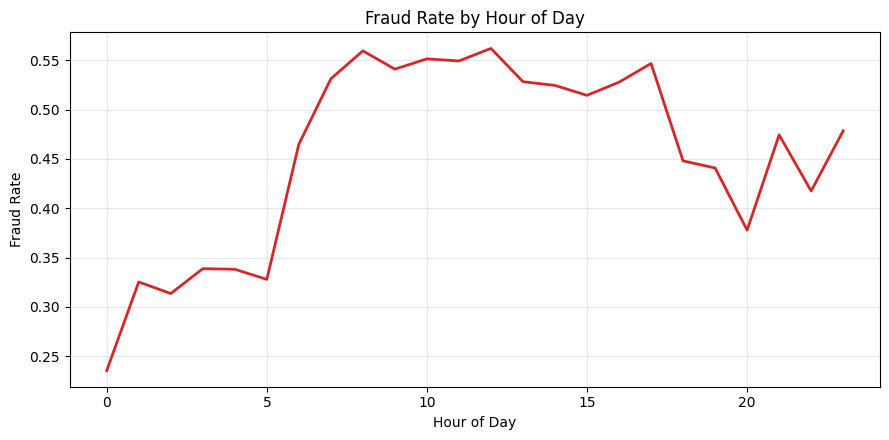

In [65]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

hour_pd = (
    predictions
    .groupBy("hour")
    .agg(avg("label").alias("fraud_rate"))
    .orderBy("hour")
    .toPandas()
)

plt.figure(figsize=(9,4.5))
plt.plot(
    hour_pd["hour"],
    hour_pd["fraud_rate"],
    color="#d62728",   # red = risk
    linewidth=2
)

plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Amount Size vs Fraud Probability

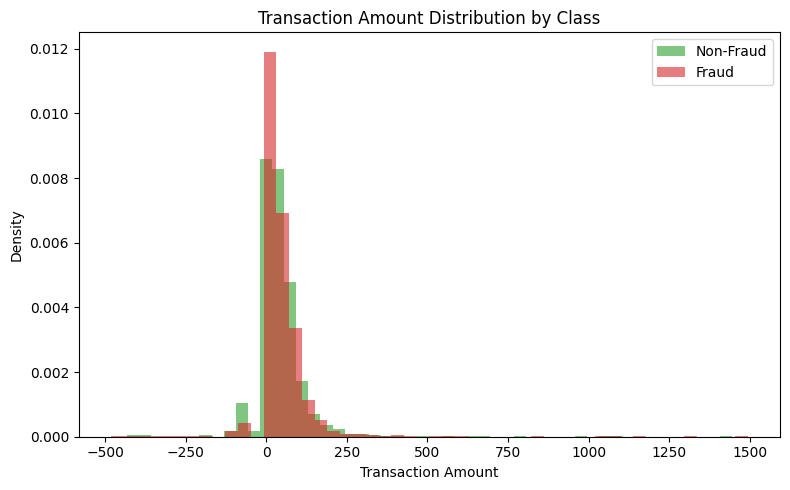

In [68]:
sample_pd = (
    predictions
    .select("amount_clean", "label")
    .sample(False, 0.02, seed=42)
    .toPandas()
)

plt.figure(figsize=(8,5))

plt.hist(
    sample_pd[sample_pd["label"] == 0]["amount_clean"],
    bins=50,
    alpha=0.6,
    density=True,
    label="Non-Fraud",
    color="#2ca02c"
)

plt.hist(
    sample_pd[sample_pd["label"] == 1]["amount_clean"],
    bins=50,
    alpha=0.6,
    density=True,
    label="Fraud",
    color="#d62728"
)

plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.title("Transaction Amount Distribution by Class")
plt.legend()
plt.tight_layout()
plt.show()
